# Wisconsin Breast Cancer [Diagnosis]

## Modules

In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
from neuralsens import partial_derivatives as ns
from joblib import dump

from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set()
set_config(display='diagram')

d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


torch installation could not be found, only numpy activation functions allowed


## Loading data

In [2]:
file_path = os.path.join(os.getcwd(), '../data/breast-cancer.csv')
df = pd.read_csv(file_path)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## EDA

In [3]:
print('Null values:', df.isnull().sum().sum())
print('NaN values:', df.isna().sum().sum())
print("Duplicates:", df.duplicated().sum())

Null values: 0
NaN values: 0
Duplicates: 0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
# df.drop(['id'], axis=1, inplace=True) 
df = df.set_index('id')

In [7]:
d = df['diagnosis'].unique()
print("Diagnosis labels:", d)

Diagnosis labels: ['M' 'B']


In [8]:
# We encode target variable as category and encode its label
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'].astype('category'))

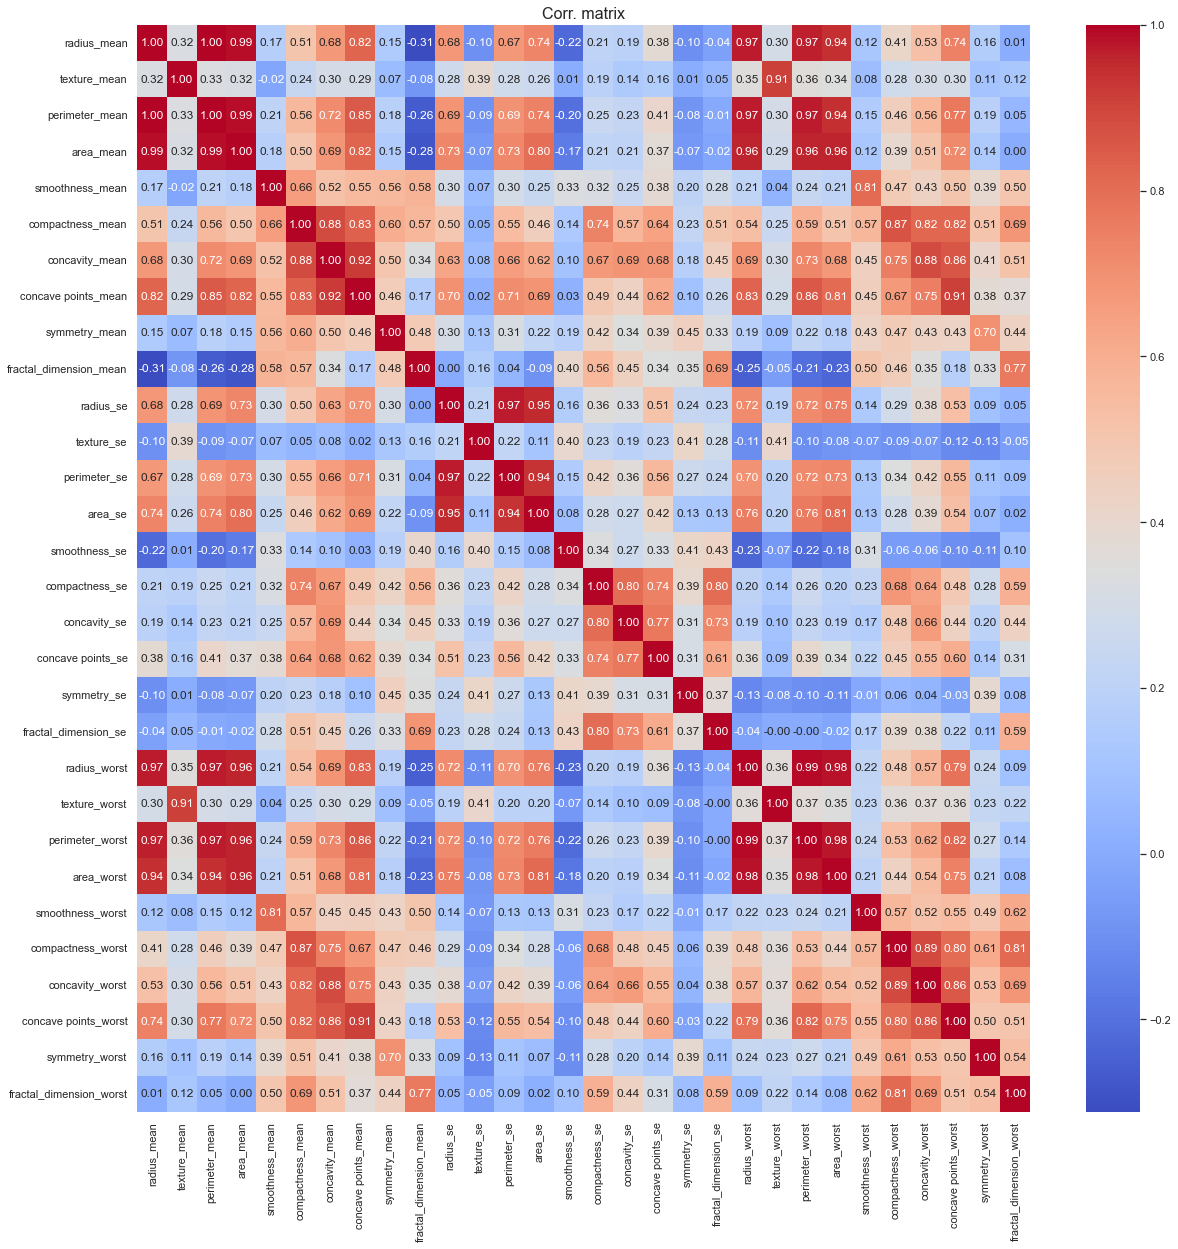

In [ ]:
def corrMatrix(df:pd.DataFrame, title:None):
    plt.figure(figsize=(20,20))
    df_corr = df.select_dtypes(include=['int64','float64']).corr()
    sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title, fontsize=16)
    plt.show()

# We can see some highly correlated variables, some make sense due to their mathematical formulation or meaning: parameter-radius and area-radius or concave_points-concavity; 
# other might provide some insight: concave_points-radius

corrMatrix(df, 'Corr. matrix')

In [ ]:
# Preprocessing the values to perform PCA
numeric_features = df.select_dtypes(include=['int64','float64']).columns.values.tolist()
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X=df[numeric_features])

In [ ]:
pca = PCA(n_components=X_transformed.shape[1],)
X_pca = pca.fit_transform(X_transformed)

In [ ]:
exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_, index = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)], columns=['Exp_variance'])
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance

,Exp_variance,cum_Exp_variance
PC1,0.442720,0.442720
PC2,0.189712,0.632432
PC3,0.093932,0.726364
PC4,0.066021,0.792385
PC5,0.054958,0.847343
PC6,0.040245,0.887588
PC7,0.022507,0.910095
PC8,0.015887,0.925983
PC9,0.013896,0.939879
PC10,0.011690,0.951569


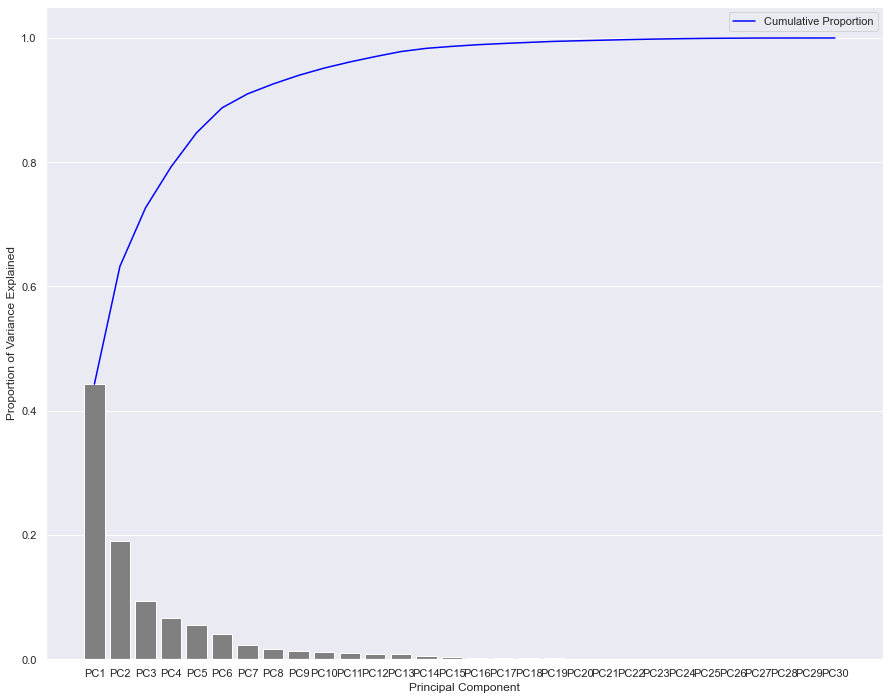

In [ ]:
fig = plt.figure(figsize=(15,12))
sns.barplot(data=exp_variance, x=exp_variance.index, y='Exp_variance', color='gray')
sns.lineplot(data=exp_variance, x=exp_variance.index, y='cum_Exp_variance', color='blue', label='Cumulative Proportion')
plt.gca().set_ylabel('Proportion of Variance Explained')
plt.gca().set_xlabel('Principal Component')
plt.legend()
plt.show()

If we analyze the first three PC:
- PC1 seems to be a size variable with all loadings positive
- PC2 has positive loadings in variables that are not radius, area, texture y perimeter and negative loadings in those. It seems to be a measure of the shape characteristics of the nuclei but inversely related to the size.
- PC3 has for all standard error measures positive loadings, while wost measures have negative loadings (except for radius, area, texture and perimeter). PC3 seems to reflect the variability in shape measures penalizing worst measures and giving a positive effect to standard errors.

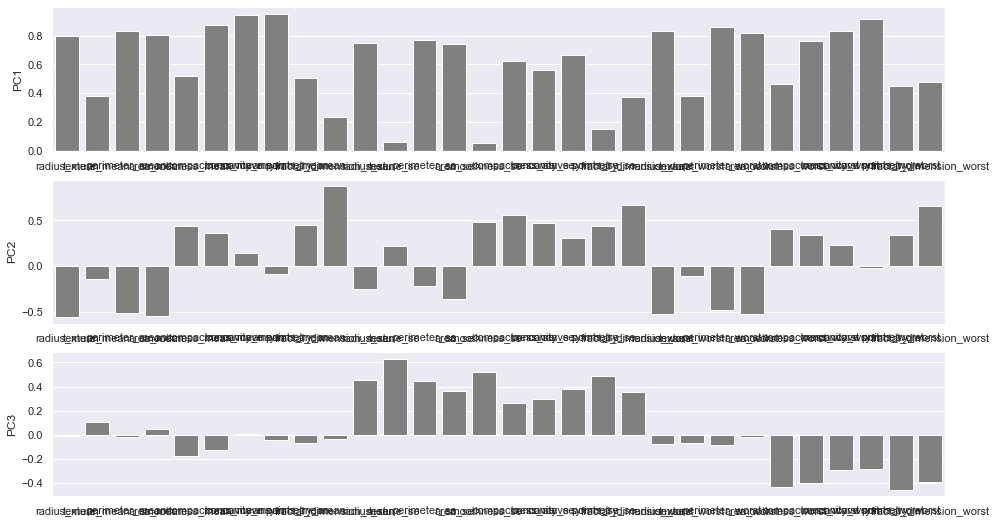

In [ ]:
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=['PC' + str(pca + 1) for pca in range(pca.n_components)], index=numeric_features)

fig, axes = plt.subplots(3, 1, figsize=(16,9))
PC = 0
for ax in axes.ravel():
    sns.barplot(data=loadings, x=loadings.index, y=loadings.columns.values.tolist()[PC], color='gray', ax=ax)
    PC += 1

Looking at the cumulative explained variance a reasonable amount of PC to choose is 7 with which we will have 91% of variance explained or 10 to go a bit deeper and get 95%

In [ ]:
# Assuming you have defined X_train and y_train
X_train = df.drop('diagnosis', axis=1)
y_train = df.diagnosis

# Create a pipeline with Lasso regularization
lasso_model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear'))

# Define a grid of C values to search
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a GridSearchCV object
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='f1')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best C:", best_params['logisticregression__C'])

In [ ]:
from scipy.stats import norm, binom_test
import math

# Summary for Logistic Regression model from scikit
def summaryLogReg(modelpipe, X: pd.core.frame.DataFrame, y: pd.core.series.Series):
    """Summary of scikit 'LogisticRegression' models.
    
    Provide feature information of linear regression models,
    such as coefficient, standard error and p-value. It is adapted
    to stand-alone and Pipeline scikit models.
    
    Important restriction of the function is that LogisticRegression 
    must be the last step of the Pipeline.
    Args:
        model: LogisticRegression or Pipeline model
        X (pd.core.frame.DataFrame): Input variables dataframe
        y (pd.core.series.Series): Output variable series
    """
    # Select model from pipeline
        # Obtain coefficients of the model
    if type(modelpipe) is not LogisticRegression:
        model = modelpipe[len(modelpipe) - 1]  
        prep = modelpipe[len(modelpipe) - 2] 
        # Obtain names of the inputs
        try:
            coefnames = [x.split("__")[1] for x in  list(prep.get_feature_names_out())]
        except:
            coefnames = list(prep.get_feature_names_out())
    else:
        model = modelpipe  
        prep = []
        # Obtain names of the inputs
        coefnames = [column for column in X.columns]
    
    # Obtain coefficients of the model
    coefs = model.coef_[0]
    intercept = model.intercept_
    if not intercept == 0:
        coefs = np.append(intercept,coefs)
        coefnames.insert(0,'Intercept')
    # Calculate matrix of predicted class probabilities.
    # Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
    predProbs = modelpipe.predict_proba(X)
    y_pred = predProbs[:,1]
    y_int = y#.cat.codes.to_numpy()
    res = y_int - y_pred
    print('Deviance Residuals:')
    quantiles = np.quantile(res, [0,0.25,0.5,0.75,1], axis=0)
    quantiles = pd.DataFrame(quantiles, index=['Min','1Q','Median','3Q','Max'])
    print(quantiles.transpose())
    # Print coefficients of the model
    print('\nCoefficients:')
    coefs = pd.DataFrame(data=coefs, index=coefnames, columns=['Estimate'])
    ## Calculate std error of inputs ------------- 
    #scale if necessary and build Xdesign
    if prep:
        X_trainMOD = prep.fit_transform(X)
    else:
        X_trainMOD = X
    
    if not intercept == 0:
        X_design = np.hstack([np.ones((X.shape[0], 1)), X_trainMOD])
    else:
        X_design = X_trainMOD
    # Initiate matrix of 0's, fill diagonal with each predicted observation's variance
    V = np.diagflat(np.product(predProbs, axis=1))
    # Covariance matrix
    covLogit = np.linalg.inv(X_design.T @ V @ X_design)
    print(coefs)
    # Std errors
    coefs['Std. Err'] = np.sqrt(np.diag(covLogit))
    # t-value
    coefs['t-value'] = coefs['Estimate'] / coefs['Std. Err']
    # P-values
    coefs['Pr(>|t|)'] = (1 - norm.cdf(abs(coefs['t-value']))) * 2
    coefs['Signif'] = coefs['Pr(>|t|)'].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else ('.' if x < 0.1 else ' '))))
    print(coefs)
    print('---\nSignif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1')
    ## AIC criterion ----------------
    # Obtain rank of the model
    rank = len(coefs)
    likelihood = y_pred * y_int + (1 - y_pred) * (1 - y_int)
    AIC = 2*rank - 2*math.log(likelihood.max())
    #print('AIC:',AIC,' (no es fiable, revisar formula de AIC)')
    return

In [ ]:
summaryLogReg(LogReg_fit,X_train, y_train)

In [ ]:
lr = LogReg_fit.named_steps['LogReg']
print("Classes: ", lr.classes_)
coefficients = pd.DataFrame(lr.coef_, columns=X_train.columns.tolist())
coefficients['intercept'] = lr.intercept_
print("Intercept: ", lr.intercept_)
coefficients

### Decision Tree

PCA-DT Trained
Best params:
 {'DT__criterion': 'entropy', 'DT__max_depth': 7, 'pca__n_components': 11}


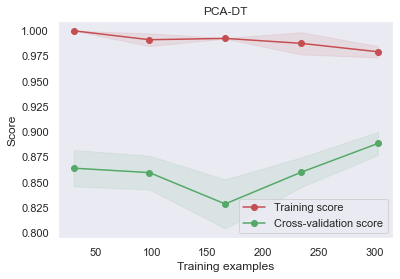

In [ ]:
param = {
    'pca__n_components': np.arange(7,15), # Again we obtain ~10 as result makes sense
    'DT__max_depth': np.arange(1, 30, 3),
    'DT__criterion': ['entropy', 'gini'],
}

pipe = Pipeline(steps=[('scaler',StandardScaler()),
                       ('pca', PCA()),
                       ('DT', DecisionTreeClassifier(random_state=42))]) 
                                                     
model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'PCA-DT', cv=3, learning=True)

In [ ]:
model_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

<Figure size 1080x864 with 0 Axes>

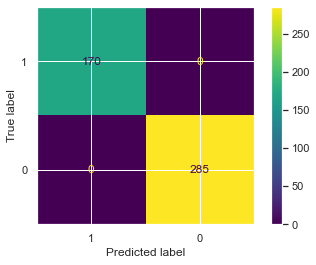

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Balanced Accuracy: 1.000000
F1 Score: 1.000000


<Figure size 1080x864 with 0 Axes>

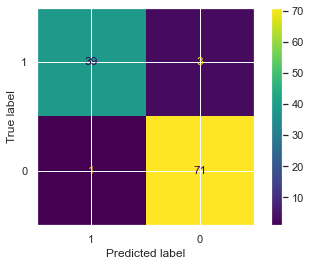

Accuracy: 0.964912
Precision: 0.975000
Recall: 0.928571
Balanced Accuracy: 0.957341
F1 Score: 0.951220


In [ ]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'DecisionTree')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'DecisionTree')

In [ ]:
# Obtain Cross-Validation score
print("Training F1 score is:", cross_val_score(LogReg_fit, X_train, y_train, cv=5, scoring='f1').mean())
print("Training recall is:", cross_val_score(LogReg_fit, X_train, y_train, cv=5, scoring='recall').mean())
print("Training precision is:", cross_val_score(LogReg_fit, X_train, y_train, cv=5, scoring='precision').mean())

Training F1 score is: 0.96963503289879
Training recall is: 0.9588235294117646
Training precision is: 0.9830065359477125


In [ ]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['DTree'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

,acc,prec,recall,bal_acc,f1
model,,,,,
baseline,0.964912,0.975000,0.928571,0.957341,0.951220
LogReg,0.982456,1.000000,0.952381,0.976190,0.975610
RandomForest,0.956140,0.974359,0.904762,0.945437,0.938272
XGBoost,0.964912,0.975000,0.928571,0.957341,0.951220
DecisionTree,0.964912,0.975000,0.928571,0.957341,0.951220


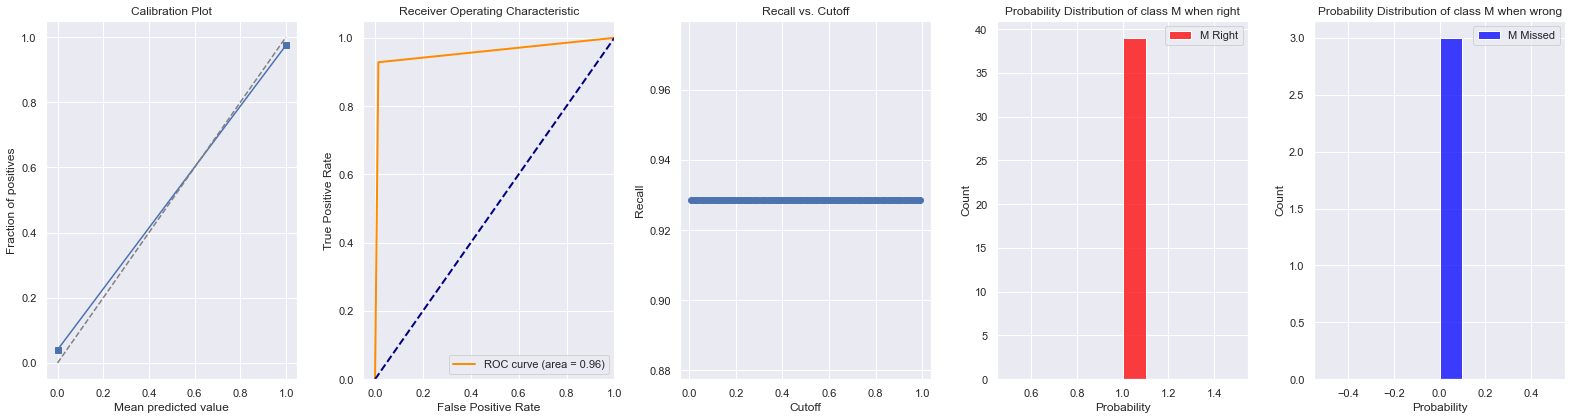

In [ ]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

In [ ]:
# Looking at features importance doesnt give much information since we have applied PCA so the graph is a bit misleading
importances_rf = permutation_importance(model_fit, 
                                        X_train, y_train,
                                        n_repeats=10,
                                        random_state=42)

fig = plt.figure(2, figsize=(22, 6)) 
plt.barh(INPUTS, importances_rf.importances_mean, yerr=importances_rf.importances_std)
plt.ylabel('Feature')
plt.xlabel('Permutation Importance')
plt.grid()
plt.show()

### XGBoost

PCA-XGBoost Trained
Best params:
 {'pca__n_components': 10, 'xgb__learning_rate': 0.30000000000000004, 'xgb__n_estimators': 70}


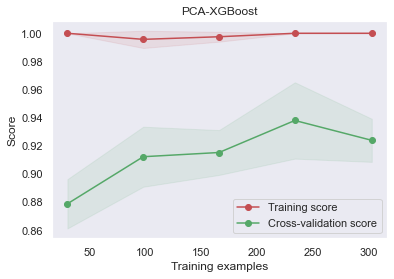

In [ ]:
param = {
    'pca__n_components': np.arange(7,15), 
    'xgb__n_estimators': np.arange(50,100,10),  
    'xgb__learning_rate': np.arange(0.1,0.31,0.05),  # Con 0.4 me ha salido 0.951220 como antes
}

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]) 

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'PCA-XGBoost', cv=3, learning=True)

<Figure size 1080x864 with 0 Axes>

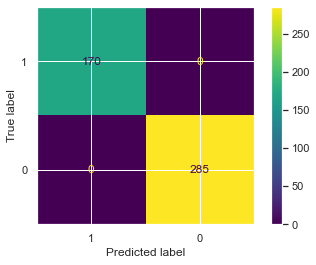

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Balanced Accuracy: 1.000000
F1 Score: 1.000000


<Figure size 1080x864 with 0 Axes>

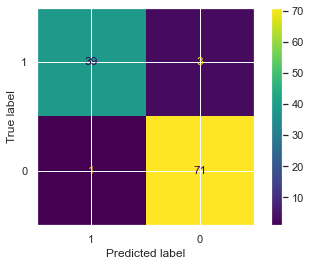

Accuracy: 0.964912
Precision: 0.975000
Recall: 0.928571
Balanced Accuracy: 0.957341
F1 Score: 0.951220


In [ ]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'XGBoost')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'XGBoost')

In [ ]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['XGBoost'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

,acc,prec,recall,bal_acc,f1
model,,,,,
baseline,0.964912,0.975000,0.928571,0.957341,0.951220
LogReg,0.982456,1.000000,0.952381,0.976190,0.975610
RandomForest,0.956140,0.974359,0.904762,0.945437,0.938272
XGBoost,0.964912,0.975000,0.928571,0.957341,0.951220


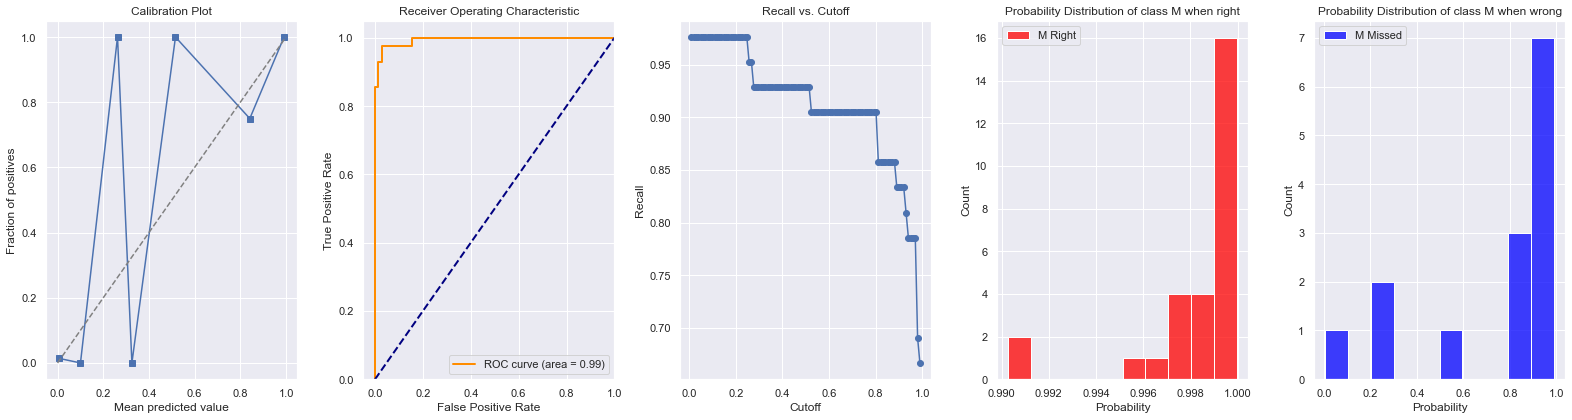

In [ ]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

In [ ]:
mlp = model_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity', model_fit.best_estimator_['MLP'].get_params()['activation'], mlp.out_activation_]

X = model_fit.best_estimator_['pca'].transform(model_fit.best_estimator_['scaler'].transform(X_train))
X = pd.DataFrame(X, columns=[f'PC{i}' for i in range(1,11)])
y = pd.DataFrame(y_train)

sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y, use_torch=False)

In [ ]:
# No new information from the sensitivity analysis, the most important PC is the first and then descending
sensmlp.summary()

Sensitivity analysis of [10, 10, 1] MLP network.

Sensitivity measures of each output:

$diagnosis 

          mean       std  mean_squared
PC1   0.042424  0.137801      0.144184
PC2  -0.028100  0.087112      0.091532
PC3  -0.017540  0.065066      0.067388
PC4  -0.012824  0.042573      0.044462
PC5  -0.024854  0.075617      0.079597
PC6  -0.006717  0.021000      0.022048
PC7  -0.006647  0.028464      0.029230
PC8  -0.014188  0.053774      0.055614
PC9   0.026850  0.081812      0.086106
PC10  0.023981  0.072195      0.076074


In [ ]:
sensmlp.info()

Sensitivity analysis of [10, 10, 1] MLP network.

455 samples

Sensitivities of each output (only 5 first samples):

$diagnosis 

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.038184 -0.023308 -0.027557 -0.011214 -0.022414 -0.001707 -0.007292   
1  0.000082 -0.000048 -0.000040 -0.000004 -0.000093 -0.000037 -0.000080   
2  0.000271 -0.000449  0.000315 -0.000206 -0.000187 -0.000245  0.000055   
3  0.005056 -0.005070 -0.008023 -0.001330 -0.008879 -0.002569 -0.009140   
4  0.000131 -0.000110 -0.000131 -0.000047 -0.000117 -0.000021 -0.000070   

        PC8       PC9      PC10  
0 -0.017115  0.021436  0.021532  
1  0.000014  0.000095  0.000100  
2  0.000004  0.000289  0.000179  
3  0.000733  0.007633  0.010279  
4 -0.000052  0.000102  0.000120  


d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1080x864 with 0 Axes>

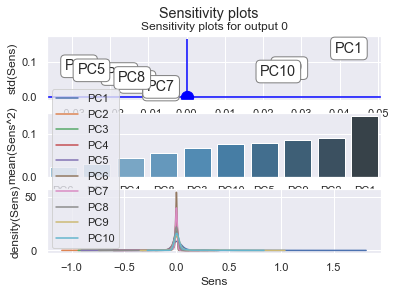

In [ ]:
plt.figure(figsize=(15,12))
sensmlp.plot()
plt.show()